# Reddit Data Analysis
## Submitter: Swetha Holla Umashankara
### Introduction

#### Install prerequisite 

In [314]:
!pip install pyvis
!pip install nltk
!pip install vaderSentiment
!pip install textstat
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

   ---------------------------------------- 0.0/105.3 kB ? eta -:--:--
   ----------------------- ---------------- 61.4/105.3 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 105.3/105.3 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/939.4 kB ? eta -:--:--
   ------------ --------------------------- 286.7/939.4 kB 8.9 MB/s eta 0:00:01
   -------------------------- ------------- 614.4/939.4 kB 7.7 MB/s eta 0:00:01
   ---------------------------------------  931.8/939.4 kB 7.4 MB/s eta 0:00:01
   ---------------------------------------- 939.4/939.4 kB 6.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB 9.6 MB/s eta 0:00:01
   ------ --------------------------------- 0.3/2.1 MB 10.2 MB/s eta 0:00:01
   -------------------- ------------------- 1.0/2.1 MB 9.5 MB/s eta 0:00:01
   ------------------------ --------------- 1.3/2.1 MB 8.1 MB/s eta 0:00:01
   --

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Alabaster\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alabaster\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alabaster\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Library needed

In [41]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain # delete
from pyvis.network import Network
import numpy as np
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textstat import flesch_reading_ease
import seaborn as sns

***************************************************************************************************************************

#### Data gathering, cleaning and formating

In [80]:
# Define the full file paths
submissions_path = r"S:\book\courseworks\webscience\Mlevel\Data\InvestmentClub_submissions_refined.json"
comments_path = r"S:\book\courseworks\webscience\Mlevel\Data\InvestmentClub_comments_refined.json"

# Load JSON files
def load_json(file_path, n=100):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# Load submissions and comments
submissions = load_json(submissions_path)
comments = load_json(comments_path)

# Convert to DataFrame
df_submissions = pd.DataFrame(submissions)
df_comments = pd.DataFrame(comments)

# Extract relevant columns
df_submissions = df_submissions[['id', 'author','selftext','title','downs','ups','score','name','created_utc']]  # Submission ID and author
df_comments = df_comments[['id', 'author', 'parent_id', 'link_id','body','downs','score','ups','created_utc','permalink']]  # Comment ID, author, parent (submission/comment)

# Merge the comments and submissions, create trimmed id for joining the data. 
df_comments['link_id'] = df_comments['link_id'].astype(str)
df_comments['trimmed_id'] = df_comments['link_id'].str.split('_').str[-1]

##### Merge data

In [82]:
df_merge = pd.merge(df_comments, df_submissions, left_on='trimmed_id', right_on='id', how='inner')
print("merge columns names: \n",df_merge.columns)
# cleaning data for further processing
# 1. Rename table names of df_merge
df_merge.rename(columns={'id_x': 'comments_id', 'author_x': 'comments_author',
                         'downs_x': 'comments_downs', 'score_x': 'comments_score', 
                         'ups_x': 'comments_ups', 'created_utc_x': 'comments_created_utc', 
                         'id_y': 'submissions_id',  'author_y': 'submissions_author', 
                         'downs_y': 'submissions_downs', 'ups_y': 'submissions_ups', 
                         'score_y': 'submissions_score', 'created_utc_y': 'submissions_created_utc'}, inplace=True)
print("New merge columns names: \n",df_merge.columns)

merge columns names: 
 Index(['id_x', 'author_x', 'parent_id', 'link_id', 'body', 'downs_x',
       'score_x', 'ups_x', 'created_utc_x', 'permalink', 'trimmed_id', 'id_y',
       'author_y', 'selftext', 'title', 'downs_y', 'ups_y', 'score_y', 'name',
       'created_utc_y'],
      dtype='object')
New merge columns names: 
 Index(['comments_id', 'comments_author', 'parent_id', 'link_id', 'body',
       'comments_downs', 'comments_score', 'comments_ups',
       'comments_created_utc', 'permalink', 'trimmed_id', 'submissions_id',
       'submissions_author', 'selftext', 'title', 'submissions_downs',
       'submissions_ups', 'submissions_score', 'name',
       'submissions_created_utc'],
      dtype='object')


In [84]:
# 2. order based on created_utc of submissions
df_merge['comments_created_utc'] = pd.to_numeric(df_merge['comments_created_utc'], errors='coerce')
df_merge = df_merge.sort_values('comments_created_utc')

# 3. remove any duplicates
dup_merge = df_merge.duplicated().sum()
print("count of duplicates records: ", dup_merge, "Old shape: ",df_merge.shape)
#    Remove duplicates only if there are any
if dup_merge != 0:
    df_merge = df_merge.drop_duplicates()
    print("Duplicates removed. New shape:", df_merge.shape)
else:
    print("No duplicates found.")

# 4. check Missing Values 
print("count of missing values: ", df_merge.isna().sum())  

# 5. Standardize Text Data of title, body, selftext
df_merge['title'] = df_merge['title'].str.strip().str.lower()
df_merge['body'] = df_merge['body'].str.strip().str.lower()
df_merge['selftext'] = df_merge['selftext'].str.strip().str.lower()

count of duplicates records:  1 Old shape:  (22863, 20)
Duplicates removed. New shape: (22862, 20)
count of missing values:  comments_id                   0
comments_author               0
parent_id                     0
link_id                       0
body                          0
comments_downs                0
comments_score                0
comments_ups                  0
comments_created_utc          0
permalink                  6422
trimmed_id                    0
submissions_id                0
submissions_author            0
selftext                      0
title                         0
submissions_downs             0
submissions_ups               0
submissions_score             0
name                          0
submissions_created_utc       0
dtype: int64


#### Details about the Most commented post

In [37]:
# Find the total author names.
unique_authors = df_merge['comments_author'].nunique() # Get total author names
print(f"Total commenters: {unique_authors}")

comment_authors = df_merge.dropna(subset=['comments_author'])['comments_author']
submission_authors = df_merge.dropna(subset=['submissions_author'])['submissions_author']

# Compute the union of unique users
unique_users = set(comment_authors).union(set(submission_authors))
print("Total Unique Users: ", len(unique_users))  # Total unique users

# Find users who commented but never posted
only_commenters = set(comment_authors) - set(submission_authors)
print("Total Users who commented but never posted: ", len(only_commenters))

# Get unique users who posted submissions
num_posters = len(submission_authors)
print("Total Unique users who posted submissions: ", num_posters)

# Find users who did both (intersection)
both_comment_and_post = set(comment_authors).intersection(set(submission_authors))
print("Total number of people who have commented and posted: ", len(both_comment_and_post))

#top users
top_users = df_merge['submissions_author'].value_counts()

# Define super user threshold (top 10% active users)
threshold = top_users.quantile(0.95)

# Filter super users
super_users = top_users[top_users >= threshold]

# Convert to DataFrame for better readability
df_super_users = super_users.reset_index()
df_super_users.columns = ["User", "Total Posts"]

# Display the top super users
print("\nTop users and posts: \n", df_super_users)

Total commenters: 7226
Total Unique Users:  8898
Total Users who commented but never posted:  6107
Total Unique users who posted submissions:  22862
Total number of people who have commented and posted:  1119

Top users and posts: 
               User  Total Posts
0           Zurevu         3258
1        [deleted]         2244
2       The-Techie          355
3          Jeffbak          226
4    EffectiveWait          225
..             ...          ...
140        kurt_FI           23
141  Savagedaddy18           23
142   HomegymRambo           23
143     fig1newton           23
144         dkiels           23

[145 rows x 2 columns]


In [23]:
# post with most number of comments and number submissions per user 
# Count comments per post
most_commented_post = df_merge['link_id'].value_counts().idxmax()
print(f"Post with most comments: {most_commented_post}")

# Filter the DataFrame to find authors who commented on this post
most_commented_post_authors = df_merge[df_merge['link_id'] == most_commented_post]['comments_author'].unique()
most_commented_post_title = df_merge[df_merge['link_id'] == most_commented_post]['title'].unique()
print(f"Authors who commented on the most commented post: {most_commented_post_authors}")
print(f"Title of the submission with most commented post: {most_commented_post_title}")

# Count submissions per user
submissions_per_user = df_merge['submissions_author'].value_counts()
print(f"Average number of submissions per user: {round(submissions_per_user.mean(),4)}")

Post with most comments: t3_pud5i4
Authors who commented on the most commented post: ['Grave_Warden' 'jansej' 'Jeffbak' 'chernokicks' 'KingWooz' 'doumination'
 'cashrichman' 'cryptofundamentalism' '[deleted]' 'Known_Abrocoma9214'
 'RemindMeBot' 'suuupreddit' 'MisterMaury' 'TheNewUsed' 'fm1michael1'
 'ebooksnz' 'henrymcgoldrick1']
Title of the submission with most commented post: ['bubble is bursting']
Average number of submissions per user: 8.1913


#### Duration of these posts and comments

In [59]:
# Compute time span of the posts
# Convert 'comments_created_utc' from Unix timestamp to datetime
df_merge['comments_created_utc'] = pd.to_datetime(pd.to_numeric(df_merge['comments_created_utc'],errors='coerce'), unit='s')
df_merge['submissions_created_utc'] = pd.to_datetime(pd.to_numeric(df_merge['submissions_created_utc'],errors='coerce'), unit='s')

start_date = df_merge['submissions_created_utc'].min()
end_date = df_merge['submissions_created_utc'].max()
time_span = f"{start_date.date()} - {end_date.date()}"
days = (end_date - start_date).days
weeks = days / 7

# First and last submission dates
first_submission_date = df_merge["submissions_created_utc"].min().date()
last_submission_date = df_merge["submissions_created_utc"].max().date()

# Compute time span of comments
start_date_comments = df_merge['comments_created_utc'].min()
end_date_comments = df_merge['comments_created_utc'].max()
time_span_comments = f"{start_date_comments.date()} - {end_date_comments.date()}"
days_comments = (end_date_comments - start_date_comments).days
weeks_comments = days_comments / 7

# First and last comment dates
first_comment_date = df_merge["comments_created_utc"].min().date()
last_comment_date = df_merge["comments_created_utc"].max().date()

# Print results
print(f"First submission date: {first_submission_date}")
print(f"Last submission date: {last_submission_date}")
print(f"First comment date: {first_comment_date}")
print(f"Last comment date: {last_comment_date}")

First submission date: 2012-02-01
Last submission date: 2022-12-31
First comment date: 2012-02-01
Last comment date: 2022-12-31


***************************************************************************************************************************

#### Network Analysis

##### creating graphs

In [72]:
# Create a directed graph
G = nx.DiGraph()

empty_count = 0

for _, row in df_merge.iterrows():
    submission_author = row.get("comments_author")  # Author of the submission
    comment_author = row.get("submissions_author")  # Author of the comment

    # Skip rows where either author is missing
    if pd.isna(submission_author) or pd.isna(comment_author):
        empty_count += 1
        continue  

    # Allow self-loops (users commenting on their own posts)
    G.add_node(submission_author, type="user")
    G.add_node(comment_author, type="user")
    G.add_edge(comment_author, submission_author)  # Commenter → Post author

In [74]:
print(f"Number of nodes: {G.number_of_nodes()}, Number of edges: {G.number_of_edges()}")

Number of nodes: 8898, Number of edges: 13847


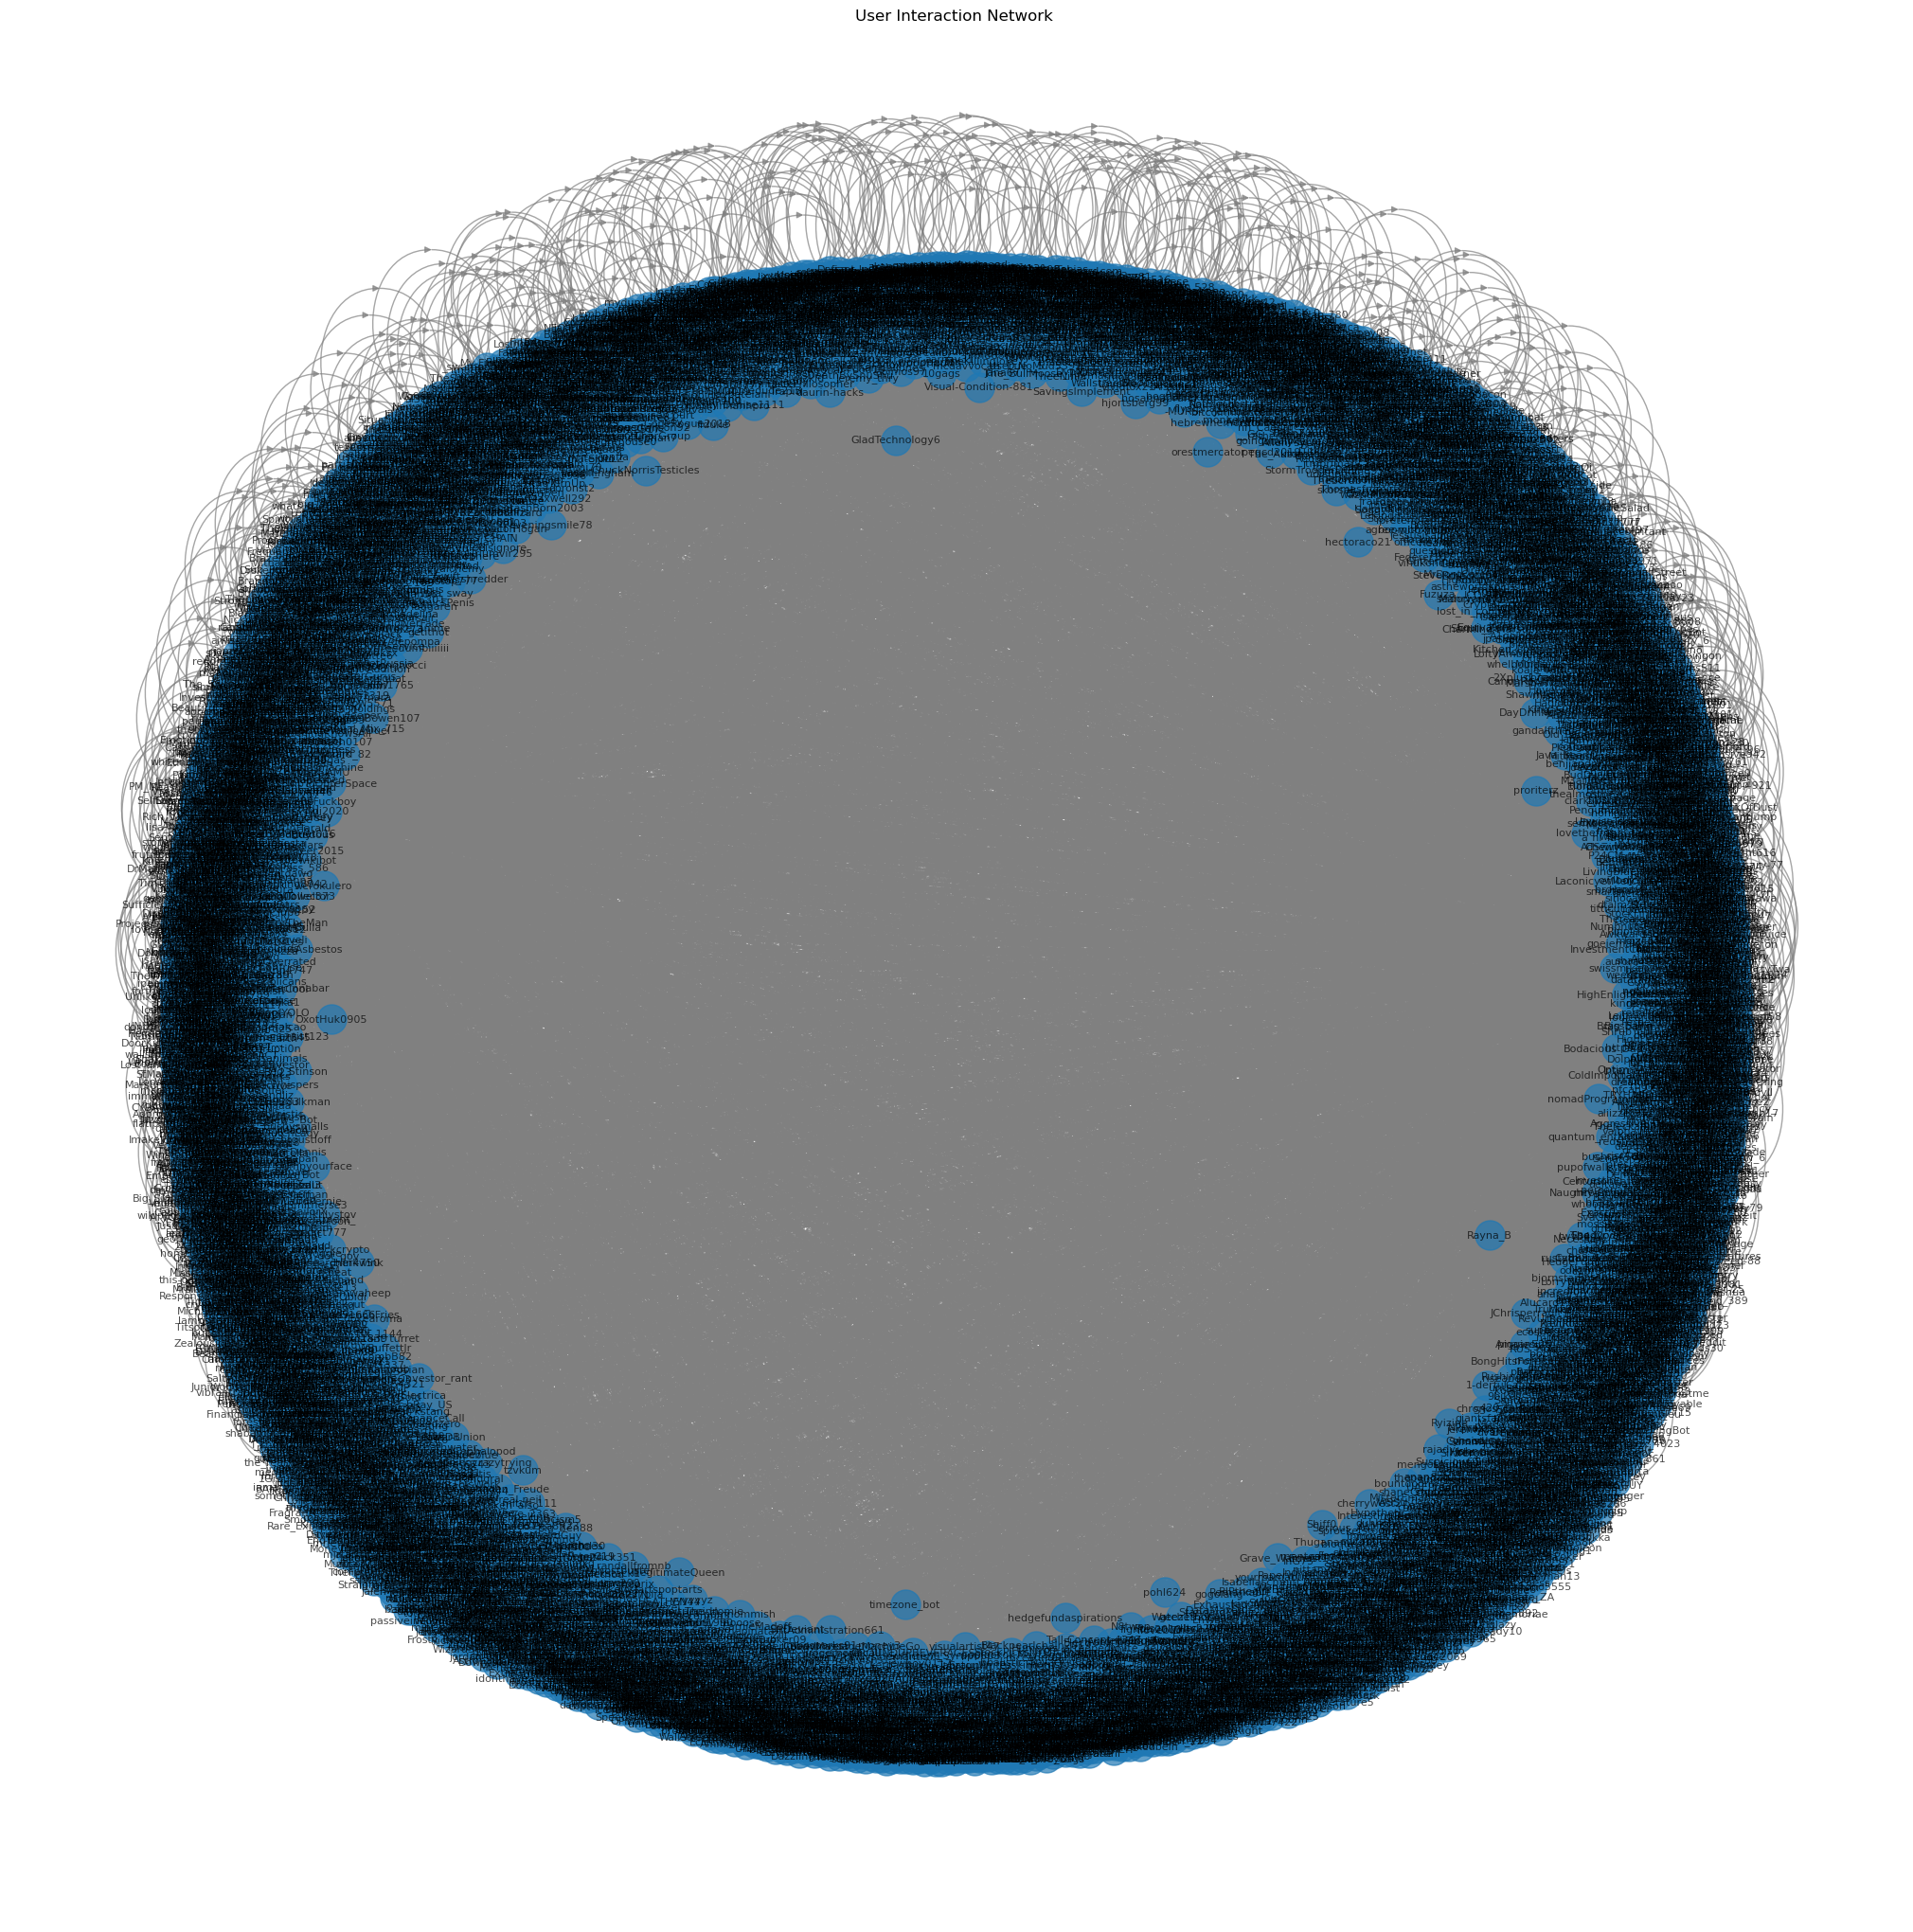

In [244]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=5)  # Spread out nodes
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, edge_color="gray", alpha=0.7)
plt.title("User Interaction Network ")
plt.show()

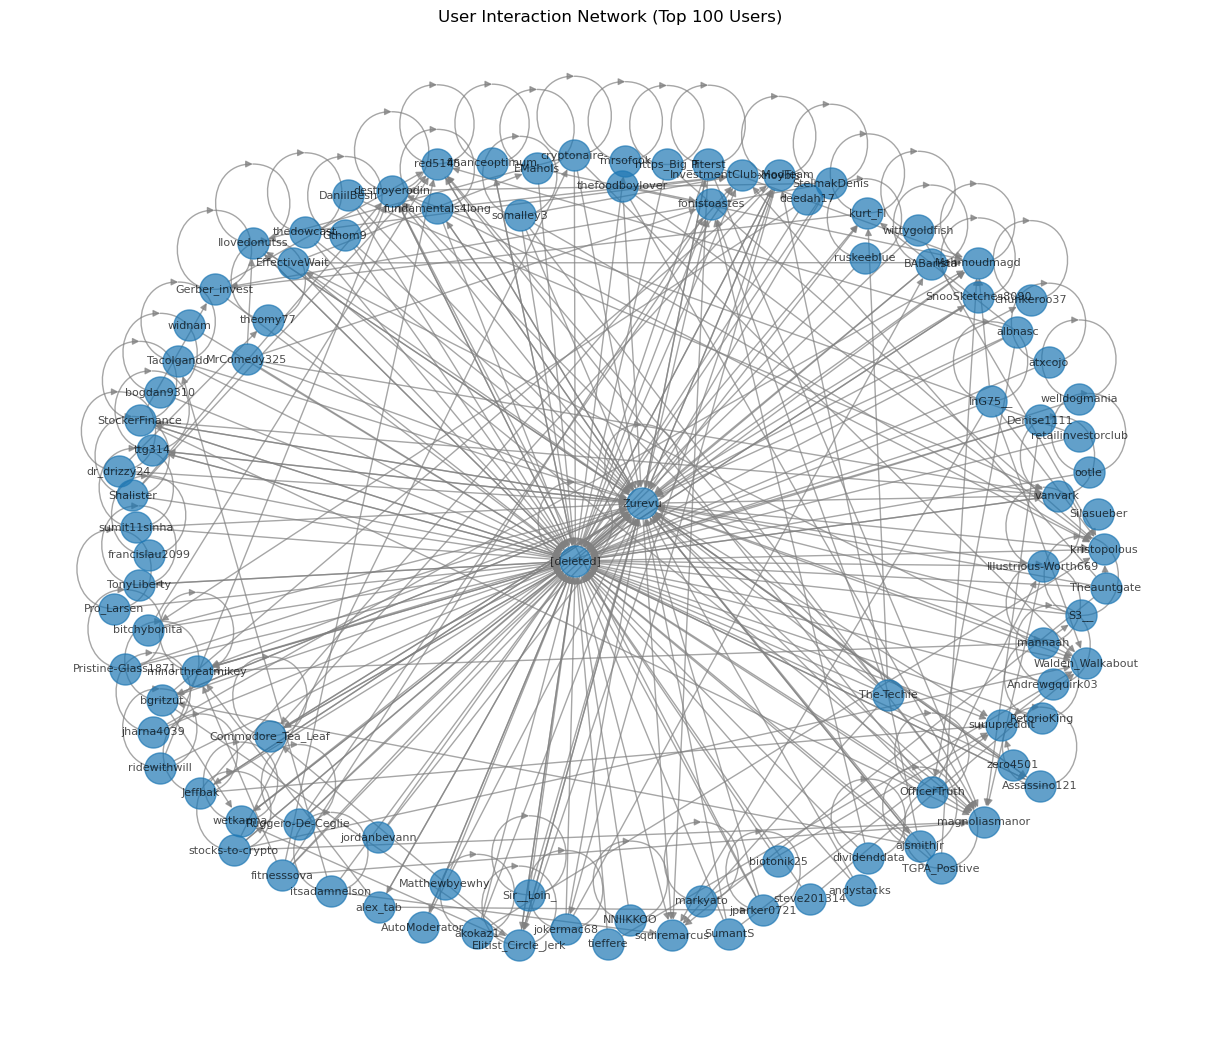

In [245]:
# Keep only the top 100 most connected users
top_users = [user for user, degree in sorted(G.degree(), key=lambda x: x[1], reverse=True)[:100]]
G_small_100 = G.subgraph(top_users)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_small_100, k=2)  
nx.draw(G_small_100, pos, with_labels=True, node_size=500, font_size=8, edge_color="gray", alpha=0.7)
plt.title("User Interaction Network (Top 100 Users)")
plt.show()

***************************************************************************************************************************

#### Analysis of the network and understand the important properties

##### Research Question 1: Who are the most influential super users in the investment network? What is the overall structure of the network?

In [76]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Find top 5 most central users based on degree centrality
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 users based on Degree Centrality:", top_degree_centrality)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 users based on Betweenness Centrality:", top_betweenness_centrality)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 users based on Degree Centrality:", top_closeness_centrality)

Top 5 users based on Degree Centrality: [('Zurevu', 0.29717882432280546), ('[deleted]', 0.1954591435315275), ('The-Techie', 0.023266269529054737), ('EffectiveWait', 0.01641002585141059), ('fitnesssova', 0.015510846352703158)]
Top 5 users based on Betweenness Centrality: [('Zurevu', 0.060022244471800004), ('[deleted]', 0.04186031961895169), ('EffectiveWait', 0.0021544026099148297), ('StockerFinance', 0.0010976802282222462), ('xnoybis', 0.0010508405924788934)]
Top 5 users based on Degree Centrality: [('Zurevu', 0.1490755447132655), ('[deleted]', 0.1297931050655958), ('squiremarcus', 0.10289732601212322), ('Walden_Walkabout', 0.10265056139832932), ('fonistoastes', 0.10249416135556903)]


##### Research Question 2: How users on support communities, as a group behave over time?

Peak traffic hour: 18:00
Peak traffic day: 2021-01-31
Peak traffic week: 2021-01-25/2021-01-31
Peak traffic month: 2021-02


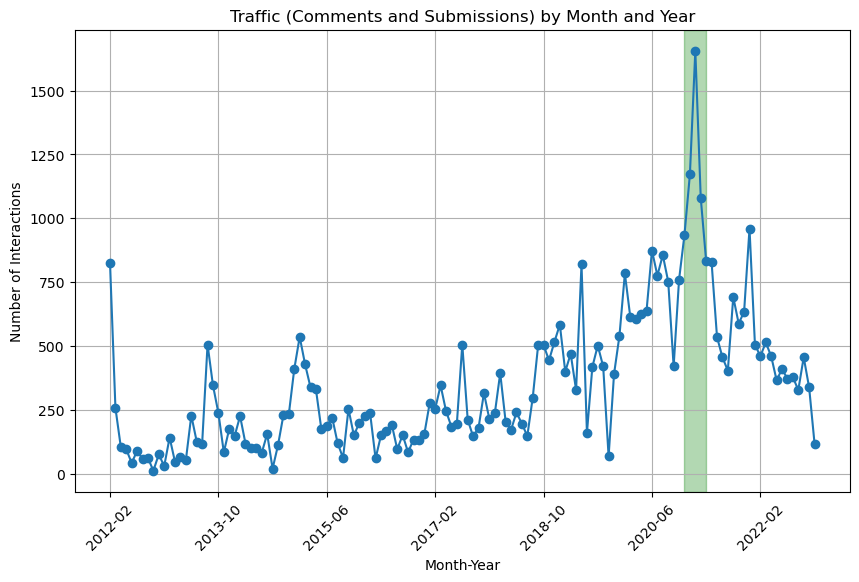

In [63]:
# Convert UTC timestamps to datetime if not already done
# Combine timestamps for both submissions and comments
df_traffic = pd.concat([
    df_merge[['submissions_created_utc']].rename(columns={'submissions_created_utc': 'timestamp'}),
    df_merge[['comments_created_utc']].rename(columns={'comments_created_utc': 'timestamp'})
])
df_traffic['activity_time'] = df_merge[['submissions_created_utc', 'comments_created_utc']].min(axis=1)

# Extract the peak hour
df_traffic['hour'] = df_traffic['activity_time'].dt.hour
df_traffic['day'] = df_traffic['activity_time'].dt.date
df_traffic['week'] = df_traffic['activity_time'].dt.to_period("W")
df_traffic['month'] = df_traffic['activity_time'].dt.to_period("M")

peak_hour = df_traffic['hour'].value_counts().idxmax()
peak_day = df_traffic['day'].value_counts().idxmax()
peak_week = df_traffic['week'].value_counts().idxmax()
peak_month = df_traffic['month'].value_counts().idxmax()

# Print results
print(f"Peak traffic hour: {peak_hour}:00")
print(f"Peak traffic day: {peak_day}")
print(f"Peak traffic week: {peak_week}")
print(f"Peak traffic month: {peak_month}")

# Group traffic data by month
traffic_data = df_traffic.groupby('month').size()

# Convert PeriodIndex to string for plotting
traffic_data.index = traffic_data.index.astype(str)

# Create numerical x-axis values
x_values = np.arange(len(traffic_data))
peak_index = list(traffic_data.index).index(str(peak_month))  # Get numerical index of peak month

# Plot the traffic graph
plt.figure(figsize=(10, 6))
plt.axvspan(peak_index - 2, peak_index + 2, color='green', alpha=0.3, label='Peak Activity')
traffic_data.plot(kind='line', marker='o')
plt.title('Traffic (Comments and Submissions) by Month and Year')
plt.xlabel('Month-Year')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [65]:
# Filter data for the peak hour
peak_data_merge = df_merge[df_merge['submissions_created_utc'].dt.to_period('M') == peak_month]

# Find the most discussed submission (the one with the highest number of comments or interactions)
most_discussed_submission = peak_data_merge['submissions_id'].value_counts().idxmax()
author_contribution = df_merge[df_merge['submissions_id'] == most_discussed_submission]['submissions_author'].value_counts().idxmax()

print(f"Most discussed submission during peak month ({peak_month}): {most_discussed_submission} by author \"{author_contribution}\"")

# Retrieve the title
most_discussed_title = df_merge[df_merge['submissions_id'] == most_discussed_submission]['title'].iloc[0]

print(f"Most discussed title during peak hour ({peak_hour}:00): \"{most_discussed_title}\"")


Most discussed submission during peak month (2021-02): lbvbr7 by author "OfficerTruth"
Most discussed title during peak hour (18:00): "you provide the ticker, i’ll provide the analysis - 3 to 4 min of pure trend analysis"


##### Research Question 3: How do investment recommendations influence the network's behaviour over time?

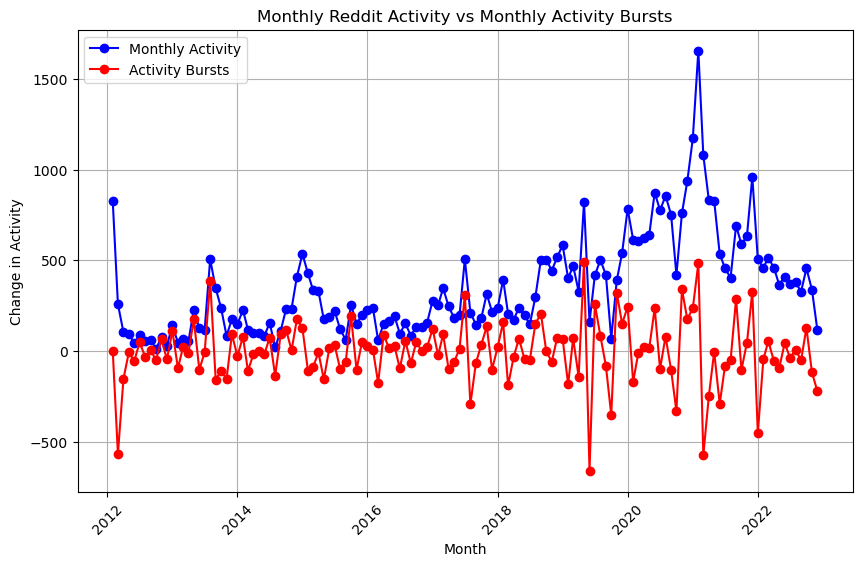

In [77]:
# Count the number of interactions per month
activity_by_month = df_traffic.groupby('month').size()

# Calculate the difference between monthly activities to detect bursts
activity_by_month_diff = activity_by_month.diff().fillna(0)

# Convert PeriodIndex to DatetimeIndex using to_timestamp() for better plotting
activity_by_month.index = activity_by_month.index.to_timestamp()

# Plot the activity by month
plt.figure(figsize=(10, 6))

plt.plot(activity_by_month.index, activity_by_month.values, marker='o', color='blue', label='Monthly Activity')
# Plot Activity Bursts
plt.plot(activity_by_month.index, activity_by_month_diff.values, marker='o', color='red', label='Activity Bursts')
plt.title('Monthly Reddit Activity vs Monthly Activity Bursts')
plt.xlabel('Month')
plt.ylabel('Change in Activity')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


***************************************************************************************************************************

#### Open Creativity Task

##### Sentiment Analyzer

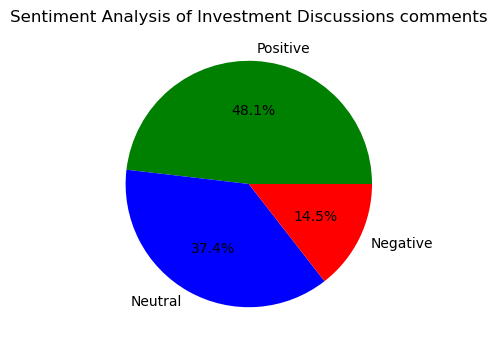

comments_sentiment_score
Positive    11007
Neutral      8547
Negative     3308
Name: count, dtype: int64


In [29]:
# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sia.polarity_scores(text)  # VADER sentiment scores
    if score['compound'] >= 0.05:
        return "Positive"
    elif score['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

def clean_data(text):
    #Remove special characters & punctuation
    #Lowercasing 
    text = text.lower()
    #Remove URLs, mentions, and hashtags
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\@\w+|\#", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = word_tokenize(text)  # Tokenize words
    #Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    #Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(words)


# Apply sentiment analysis
df_merge['comments_sentiment_score'] = df_merge['body'].apply(clean_data).apply(get_sentiment)
df_merge['submissions_sentiment_score'] = df_merge['selftext'].apply(clean_data).apply(get_sentiment)

# Count sentiment types
sentiment_counts = df_merge['comments_sentiment_score'].value_counts() 

# Plot Sentiment Distribution
plt.figure(figsize=(6, 4))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['green', 'blue','red'])
plt.title("Sentiment Analysis of Investment Discussions comments")
plt.show()

# Display sentiment counts
print(sentiment_counts)

Sentimental Analysis on body submissions

In [305]:
# Function to analyze trustworthiness
def analyze_trustworthiness(text, score, replies):
    sentiment_score = sia.polarity_scores(text)['compound']  # Sentiment polarity
    length_score = min(len(text) / 500, 1)  # Normalize length (longer = more trustworthy)
    engagement_score = min((score + len(replies)) / 50, 1)  # Normalize by upvotes & replies
    url_score = 1 if re.search(r'http[s]?://', text) else 0  # External links increase credibility
    
    # Compute final trust score (weighted sum)
    trust_score = (0.3 * sentiment_score) + (0.3 * length_score) + (0.3 * engagement_score) + (0.1 * url_score)
    return round(trust_score, 2)

In [93]:
# Function to calculate sentiment score
def get_sentiment_score(sentiment_label):
    if sentiment_label == "Neutral":
        return 10
    elif sentiment_label in ["Positive", "Negative"]:
        return 3
    return 0  # Default case if an unexpected value appears

# Function to calculate readability score
def get_readability_score(text):
    if isinstance(text, pd.Series):
        return text.apply(flesch_reading_ease)  # Apply function to each element
    return flesch_reading_ease(text)

# Function to calculate post engagement score
def get_post_engagement_score(upvotes, downvotes):
    return (upvotes - downvotes) / (upvotes + downvotes) * 10

# Function to calculate external source verification score
def get_external_source_score(links):
    if isinstance(links, pd.Series):
        return links.apply(lambda x: 10 if pd.notna(x) and x != "" else 0)
    return 10 if pd.notna(links) and links != "" else 0

# Main function to calculate trustworthiness score
def calculate_trustworthiness(post):
    # Extract features from the post
    upvotes = post['comments_ups']
    downvotes = post['comments_downs']
    text = post['body']
    links = post['permalink']
    values = df_merge['comments_sentiment_score'].apply(get_sentiment_score)

    
    # Calculate individual scores
    post_engagement_score = get_post_engagement_score(upvotes, downvotes)
    content_quality_score = values + get_readability_score(text) / 10
    external_source_score = get_external_source_score(links)
    
    # Set weights
    beta = 0.2
    gamma = 0.4
    delta = 0.1
    
    # Calculate final trustworthiness score
    trustworthiness_score = (beta * post_engagement_score) + (gamma * content_quality_score) + (delta * external_source_score)
    
    return trustworthiness_score, post_engagement_score, content_quality_score

# Calculate trustworthiness score
senti_score, engagement_score, content_quality_score= calculate_trustworthiness(df_merge)

In [105]:
# Apply trustworthiness scoring
df_merge['Trustworthiness'] = senti_score
df_merge

# Sort comments by Trustworthiness Score (Descending Order)
top_trustworthy_comments = df_merge.sort_values(by="Trustworthiness", ascending=False).head(5)

# Display the top 10 comments
for i, row in top_trustworthy_comments.iterrows():
    print(f"Rank: {i+1}")
    print(f"Username: {row['comments_author']}")  # Username of the commenter
    print(f"Author ID: {row['comments_id']}")  # Author ID for the specific comment
    print(f"Submission ID: {row['submissions_id']}")  # Submission ID of the comment
    print(f"Submission Title: {row['title']}")  # Title of the submission
    print(f"Comment ID: {row['link_id']}")  # Comment ID
    print(f"Comment: {row['body']}")  # Show first 300 characters of the comment
    print(f"Trustworthiness Score: {row['Trustworthiness']}")
    print(f"Score: {row['comments_score']}")
    print("-" * 80)  # Separator

Rank: 10805
Username: delioj
Author ID: f726ajt
Submission ID: du293g
Submission Title: intermediate level investment group
Comment ID: t3_du293g
Comment: 😬👍
Trustworthiness Score: 15.273600000000002
Score: 2
--------------------------------------------------------------------------------
Rank: 22807
Username: Password-Qwerty
Author ID: j07t13o
Submission ID: z4nemz
Submission Title: any recommendations for more investment books?
Comment ID: t3_z4nemz
Comment: 🫢
Trustworthiness Score: 15.273600000000002
Score: 1
--------------------------------------------------------------------------------
Rank: 17072
Username: Gib_GME
Author ID: gq8gcb2
Submission ID: m0fk6n
Submission Title: stimulus will cause bull run ?
Comment ID: t3_m0fk6n
Comment: ?
Trustworthiness Score: 15.273600000000002
Score: 1
--------------------------------------------------------------------------------
Rank: 8989
Username: Sulack
Author ID: efdswqe
Submission ID: al6n38
Submission Title: with all this talk about supe